# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [139]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [140]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow_ = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 18, 15, 43, 36, 409359)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [141]:
with open('../../data/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()
    
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1162389
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [142]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [145]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=6,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [146]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='3.2472823E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [147]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.80s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-21 00:00:00+00:00,-2.55,0.0,21.986542,309.685394,stockholm
1,2024-11-27 00:00:00+00:00,0.10,0.0,14.003029,287.969238,stockholm
2,2024-11-22 00:00:00+00:00,-5.05,0.0,12.245294,268.315338,stockholm
3,2024-11-19 00:00:00+00:00,1.15,0.0,5.241679,74.054535,stockholm
4,2024-11-24 00:00:00+00:00,3.65,0.0,18.899143,139.635544,stockholm
5,2024-11-23 00:00:00+00:00,-2.05,0.0,14.799459,274.184845,stockholm
6,2024-11-25 00:00:00+00:00,6.75,0.0,23.400002,194.250061,stockholm
7,2024-11-26 00:00:00+00:00,3.40,0.1,15.463244,282.094727,stockholm
8,2024-11-20 00:00:00+00:00,1.15,0.2,22.551060,343.300690,stockholm


In [148]:
"""import numpy as np
def fill_in_historical_pm25(air_quality_predictions_df, today):
    tomorrow = today + datetime.timedelta(days=1)

    today_string = today.strftime("%Y-%m-%d 00:00:00+00:00")
    print("__________")
    print(air_quality_predictions_df)
    today_data = air_quality_predictions_df.loc[air_quality_predictions_df["date"] == today_string]
    print(today_data)

    #aq_tomorrow_df = pd.DataFrame(columns=today_data.columns).astype({"pm25": "float32"})

    aq_tomorrow_dict = {"date": [tomorrow], "pm25": [np.float32(-1.0)], "pm25_1": [today_data["pm25"].iloc[0]], 
                        "pm25_2": [today_data["pm25_1"].iloc[0]], "pm25_3": [today_data["pm25_2"].iloc[0]], 
                        "city": [today_data["city"].iloc[0]], "country": [today_data["country"].iloc[0]], 
                        "street": [today_data["street"].iloc[0]], "url": [today_data["url"].iloc[0]]}
    
    aq_tomorrow_dict = {"date": [tomorrow], "pm25": [np.float32(-1.0)], "pm25_1": [today_data["pm25"].iloc[0]], 
                        "pm25_2": [today_data["pm25_1"].iloc[0]], "pm25_3": [today_data["pm25_2"].iloc[0]]}
    
    aq_tomorrow_df = pd.DataFrame(aq_tomorrow_dict)
    aq_tomorrow_df = pd.DataFrame()
    
    aq_tomorrow_df["date"] = [tomorrow]
    #aq_tomorrow_df['date'] = pd.to_datetime(aq_tomorrow_df['date']).dt.date
    aq_tomorrow_df['date'] = pd.to_datetime(aq_tomorrow_df['date'], utc=True)

    aq_tomorrow_df["pm25"] = [np.float32(-1.0)]
    aq_tomorrow_df["pm25_1"] = [today_data["pm25"].iloc[0]]
    aq_tomorrow_df["pm25_2"] = [today_data["pm25_1"].iloc[0]]
    aq_tomorrow_df["pm25_3"] = [today_data["pm25_2"].iloc[0]]
    aq_tomorrow_df["city"] = [today_data["city"].iloc[0]]
    aq_tomorrow_df["country"] = [today_data["country"].iloc[0]]
    aq_tomorrow_df["street"] = [today_data["street"].iloc[0]]
    aq_tomorrow_df["url"] = [today_data["url"].iloc[0]]
    
    return aq_tomorrow_df"""

'import numpy as np\ndef fill_in_historical_pm25(air_quality_predictions_df, today):\n    tomorrow = today + datetime.timedelta(days=1)\n\n    today_string = today.strftime("%Y-%m-%d 00:00:00+00:00")\n    print("__________")\n    print(air_quality_predictions_df)\n    today_data = air_quality_predictions_df.loc[air_quality_predictions_df["date"] == today_string]\n    print(today_data)\n\n    #aq_tomorrow_df = pd.DataFrame(columns=today_data.columns).astype({"pm25": "float32"})\n\n    aq_tomorrow_dict = {"date": [tomorrow], "pm25": [np.float32(-1.0)], "pm25_1": [today_data["pm25"].iloc[0]], \n                        "pm25_2": [today_data["pm25_1"].iloc[0]], "pm25_3": [today_data["pm25_2"].iloc[0]], \n                        "city": [today_data["city"].iloc[0]], "country": [today_data["country"].iloc[0]], \n                        "street": [today_data["street"].iloc[0]], "url": [today_data["url"].iloc[0]]}\n    \n    aq_tomorrow_dict = {"date": [tomorrow], "pm25": [np.float32(-1.0)], "p

In [ ]:
"""today_ = datetime.date.today()
today_string = today_.strftime("%Y-%m-%d 00:00:00+00:00")
today_data = air_quality_df.loc[air_quality_df["date"] == today_string]
tomorrow = today_ + datetime.timedelta(days=1)
tomorrow_string = tomorrow.strftime("%Y-%m-%d 00:00:00+00:00")

air_quality_predictions_df = pd.DataFrame()

aq_tomorrow_dict = {"date": [tomorrow_string], "pm25": [np.float32(-1.0)], "pm25_1": [today_data["pm25"].iloc[0]], 
                    "pm25_2": [today_data["pm25_1"].iloc[0]], "pm25_3": [today_data["pm25_2"].iloc[0]]}

aq_tomorrow_df = pd.DataFrame(aq_tomorrow_dict)

next_batch = weather_fg.filter((weather_fg.date >= today) & (weather_fg.date < tomorrow_)).read()
print("next_batch")
print(next_batch)
batch_data.info()
next_day_weather = batch_data.loc[batch_data["date"] < tomorrow_]
print("väder")
print(next_day_weather)
next_day = pd.concat([aq_tomorrow_df, batch_data])
print(next_day)


for i in range(len(batch_data)):
    today = today + datetime.timedelta(days=i+1)

    aq_tomorrow_df = fill_in_historical_pm25(aq_tomorrow_df, today)
    
    pd.concat([air_quality_predictions_df, aq_tomorrow_df])
    
    next_day_weather = batch_data.loc[batch_data["date"] == today]
    next_day = aq_tomorrow_df.join(batch_data, on="date")
    print(next_day)
    #retrieved_xgboost_model.predict()
    #Vi har nu pm lag för nästa dag,
    #Vill plocka väder
    #och predicta pm
    #Sen ska det värdet sparas på något sätt
    #de har lagt till den till batch för den dagen
    #-> rimlig approach att vi också gör det då

    """

'today_ = datetime.date.today()\ntoday_string = today_.strftime("%Y-%m-%d 00:00:00+00:00")\ntoday_data = air_quality_df.loc[air_quality_df["date"] == today_string]\ntomorrow = today_ + datetime.timedelta(days=1)\ntomorrow_string = tomorrow.strftime("%Y-%m-%d 00:00:00+00:00")\n\nair_quality_predictions_df = pd.DataFrame()\n\naq_tomorrow_dict = {"date": [tomorrow_string], "pm25": [np.float32(-1.0)], "pm25_1": [today_data["pm25"].iloc[0]], \n                    "pm25_2": [today_data["pm25_1"].iloc[0]], "pm25_3": [today_data["pm25_2"].iloc[0]]}\n\naq_tomorrow_df = pd.DataFrame(aq_tomorrow_dict)\n\nnext_batch = weather_fg.filter((weather_fg.date >= today) & (weather_fg.date < tomorrow_)).read()\nprint("next_batch")\nprint(next_batch)\nbatch_data.info()\nnext_day_weather = batch_data.loc[batch_data["date"] < tomorrow_]\nprint("väder")\nprint(next_day_weather)\nnext_day = pd.concat([aq_tomorrow_df, batch_data])\nprint(next_day)\n\n\nfor i in range(len(batch_data)):\n    today = today + dateti

### <span style="color:#ff5f27;">🏙️Add PM2.5 from previous days</span>

In [149]:
# Get air quality feature group
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
#get data for today
air_quality_batch = air_quality_fg.filter(air_quality_fg.date >= (today - datetime.timedelta(days = 1))).read()

air_quality_batch


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.82s) 


,date,pm25,pm25_1,pm25_2,pm25_3,country,city,street,url
0,2024-11-18 00:00:00+00:00,5.0,1.2,1.33,2.04,sweden,stockholm,erstagatan,https://api.waqi.info/feed/A78022


In [150]:
batch_data.sort_values(by="date", inplace=True)
batch_data.reset_index(drop=True, inplace=True) #testa att ta bort sen


batch_data.loc[0, "pm25_1"] = air_quality_batch["pm25"].values[0]
batch_data.loc[0, "pm25_2"] = air_quality_batch["pm25_1"].values[0]
batch_data.loc[0, "pm25_3"] = air_quality_batch["pm25_2"].values[0]

batch_data


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1,pm25_2,pm25_3
0,2024-11-19 00:00:00+00:00,1.15,0.0,5.241679,74.054535,stockholm,5.0,1.2,1.33
1,2024-11-20 00:00:00+00:00,1.15,0.2,22.551060,343.300690,stockholm,NaN,NaN,NaN
2,2024-11-21 00:00:00+00:00,-2.55,0.0,21.986542,309.685394,stockholm,NaN,NaN,NaN
3,2024-11-22 00:00:00+00:00,-5.05,0.0,12.245294,268.315338,stockholm,NaN,NaN,NaN
4,2024-11-23 00:00:00+00:00,-2.05,0.0,14.799459,274.184845,stockholm,NaN,NaN,NaN
5,2024-11-24 00:00:00+00:00,3.65,0.0,18.899143,139.635544,stockholm,NaN,NaN,NaN
6,2024-11-25 00:00:00+00:00,6.75,0.0,23.400002,194.250061,stockholm,NaN,NaN,NaN
7,2024-11-26 00:00:00+00:00,3.40,0.1,15.463244,282.094727,stockholm,NaN,NaN,NaN
8,2024-11-27 00:00:00+00:00,0.10,0.0,14.003029,287.969238,stockholm,NaN,NaN,NaN


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [151]:
for i in range(len(batch_data)):
    
    data = batch_data.loc[i:i,["pm25_1","pm25_2","pm25_3",'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']]
    
    batch_data.loc[i,'predicted_pm25'] = retrieved_xgboost_model.predict(data)

    if i < len(batch_data)-1:
        batch_data.loc[i+1, "pm25_1"] = batch_data["predicted_pm25"].iloc[i]
        batch_data.loc[i+1, "pm25_2"] = batch_data["pm25_1"].iloc[i]
        batch_data.loc[i+1, "pm25_3"] = batch_data["pm25_2"].iloc[i]

print(batch_data)

#Without lag
"""batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data"""

                       date  temperature_2m_mean  precipitation_sum  \
0 2024-11-19 00:00:00+00:00                 1.15                0.0   
1 2024-11-20 00:00:00+00:00                 1.15                0.2   
2 2024-11-21 00:00:00+00:00                -2.55                0.0   
3 2024-11-22 00:00:00+00:00                -5.05                0.0   
4 2024-11-23 00:00:00+00:00                -2.05                0.0   
5 2024-11-24 00:00:00+00:00                 3.65                0.0   
6 2024-11-25 00:00:00+00:00                 6.75                0.0   
7 2024-11-26 00:00:00+00:00                 3.40                0.1   
8 2024-11-27 00:00:00+00:00                 0.10                0.0   

   wind_speed_10m_max  wind_direction_10m_dominant       city    pm25_1  \
0            5.241679                    74.054535  stockholm  5.000000   
1           22.551060                   343.300690  stockholm  4.375211   
2           21.986542                   309.685394  stockholm  1

"batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(\n    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])\nbatch_data"

In [152]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_1                       9 non-null      float64            
 7   pm25_2                       9 non-null      float64            
 8   pm25_3                       9 non-null      float64            
 9   predicted_pm25               9 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), float64(3), obj

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [153]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
#batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1,pm25_2,pm25_3,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-19 00:00:00+00:00,1.15,0.0,5.241679,74.054535,stockholm,5.000000,1.200000,1.330000,4.375211,erstagatan,sweden,1
1,2024-11-20 00:00:00+00:00,1.15,0.2,22.551060,343.300690,stockholm,4.375211,5.000000,1.200000,1.330692,erstagatan,sweden,2
2,2024-11-21 00:00:00+00:00,-2.55,0.0,21.986542,309.685394,stockholm,1.330692,4.375211,5.000000,1.306946,erstagatan,sweden,3
3,2024-11-22 00:00:00+00:00,-5.05,0.0,12.245294,268.315338,stockholm,1.306946,1.330692,4.375211,2.170727,erstagatan,sweden,4
4,2024-11-23 00:00:00+00:00,-2.05,0.0,14.799459,274.184845,stockholm,2.170727,1.306946,1.330692,2.272026,erstagatan,sweden,5
5,2024-11-24 00:00:00+00:00,3.65,0.0,18.899143,139.635544,stockholm,2.272026,2.170727,1.306946,3.460518,erstagatan,sweden,6
6,2024-11-25 00:00:00+00:00,6.75,0.0,23.400002,194.250061,stockholm,3.460518,2.272026,2.170727,4.458706,erstagatan,sweden,7
7,2024-11-26 00:00:00+00:00,3.40,0.1,15.463244,282.094727,stockholm,4.458706,3.460518,2.272026,1.484627,erstagatan,sweden,8
8,2024-11-27 00:00:00+00:00,0.10,0.0,14.003029,287.969238,stockholm,1.484627,4.458706,3.460518,1.207741,erstagatan,sweden,9


In [154]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_1                       9 non-null      float64            
 7   pm25_2                       9 non-null      float64            
 8   pm25_3                       9 non-null      float64            
 9   predicted_pm25               9 non-null      float32            
 10  street                       9 non-null      object   

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

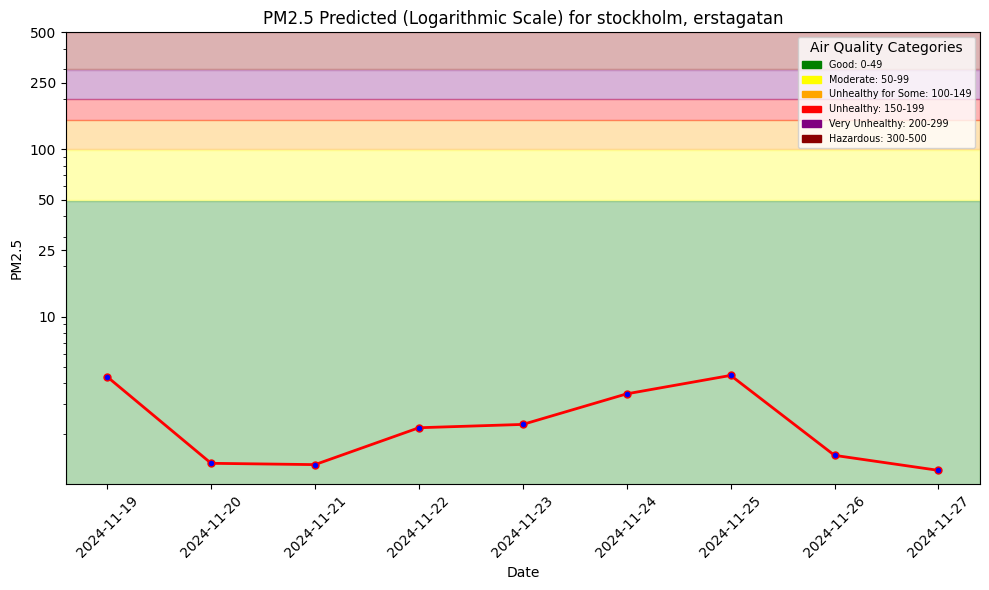

In [155]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [156]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [157]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1162389/fs/1153092/fg/1353064


Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1162389/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x1cfb6f85f60>, None)

In [158]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.65s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1,pm25_2,pm25_3,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-19 00:00:00+00:00,1.15,0.0,5.241679,74.054535,stockholm,5.0,1.2,1.33,4.375211,erstagatan,sweden,1


In [159]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.01s) 


,date,pm25,pm25_1,pm25_2,pm25_3,country,city,street,url
0,2024-04-27 00:00:00+00:00,4.45,2.52,4.30,3.63,sweden,stockholm,erstagatan,https://api.waqi.info/feed/A78022
1,2021-11-13 00:00:00+00:00,2.02,0.70,1.93,1.89,sweden,stockholm,erstagatan,https://api.waqi.info/feed/A78022
2,2021-10-21 00:00:00+00:00,0.70,3.15,1.90,0.93,sweden,stockholm,erstagatan,https://api.waqi.info/feed/A78022
3,2020-03-28 00:00:00+00:00,1.00,7.67,6.46,3.31,sweden,stockholm,erstagatan,https://api.waqi.info/feed/A78022
4,2024-07-25 00:00:00+00:00,2.58,2.00,6.30,8.52,sweden,stockholm,erstagatan,https://api.waqi.info/feed/A78022
...,...,...,...,...,...,...,...,...,...
1763,2023-05-07 00:00:00+00:00,1.73,1.52,2.00,1.47,sweden,stockholm,erstagatan,https://api.waqi.info/feed/A78022
1764,2023-08-14 00:00:00+00:00,2.97,2.60,1.73,1.52,sweden,stockholm,erstagatan,https://api.waqi.info/feed/A78022
1765,2024-01-01 00:00:00+00:00,1.80,1.80,3.00,3.00,sweden,stockholm,erstagatan,https://api.waqi.info/feed/A78022
1766,2023-09-08 00:00:00+00:00,6.15,1.58,1.08,2.35,sweden,stockholm,erstagatan,https://api.waqi.info/feed/A78022


In [160]:
def backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, model):
    features_df = weather_fg.read()
    air_quality_df["pm25_1"] = air_quality_df["pm25_1"].astype("float64")
    air_quality_df["pm25_2"] = air_quality_df["pm25_2"].astype("float64")
    air_quality_df["pm25_3"] = air_quality_df["pm25_3"].astype("float64")
    features_df = pd.merge(features_df, air_quality_df[['date','pm25','pm25_1','pm25_2','pm25_3']], on="date")
    features_df = features_df.sort_values(by=['date'], ascending=True)
    features_df = features_df.tail(10)
    features_df['predicted_pm25'] = model.predict(features_df[["pm25_1","pm25_2","pm25_3",'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    df = pd.merge(features_df, air_quality_df[['date','street','country']], on="date")
    
    #print(features_df)
    df.info()
    print("--------------")
    print(df)
    df['days_before_forecast_day'] = 1
    hindcast_df = df
    df = df.drop('pm25', axis=1)
    print("DF")
    print(df)
    monitor_fg.insert(df, write_options={"wait_for_job": True})
    return hindcast_df

In [161]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

print("pred")
print(preds_df)

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)

#drop lag?
hindcast_df = hindcast_df[["date", "pm25", "predicted_pm25"]]
hindcast_df

pred
                       date  predicted_pm25
0 2024-11-19 00:00:00+00:00        4.375211
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.00s) 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         10 non-null     datetime64[us, UTC]
 1   temperature_2m_mean          10 non-null     float32            
 2   precipitation_sum            10 non-null     float32            
 3   wind_speed_10m_max           10 non-null     float32            
 4   wind_direction_10m_dominant  10 non-null     float32            
 5   city                         10 non-null     object             
 6   pm25                         10 non-null     float32            
 7   pm25_1                       10 non-null     float64            
 8   pm25_2        

Uploading Dataframe: 0.00% |          | Rows 0/10 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1162389/jobs/named/aq_predictions_1_offline_fg_materialization/executions


,date,pm25,predicted_pm25
0,2024-11-08 00:00:00+00:00,1.92,1.543164
1,2024-11-09 00:00:00+00:00,4.55,3.416349
2,2024-11-10 00:00:00+00:00,1.20,7.201498
3,2024-11-11 00:00:00+00:00,3.33,3.739688
4,2024-11-12 00:00:00+00:00,1.20,3.733972
5,2024-11-13 00:00:00+00:00,2.24,1.624025
6,2024-11-14 00:00:00+00:00,1.95,2.333840
7,2024-11-15 00:00:00+00:00,2.04,2.367744
8,2024-11-16 00:00:00+00:00,1.33,2.638365
9,2024-11-18 00:00:00+00:00,5.00,1.811472


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

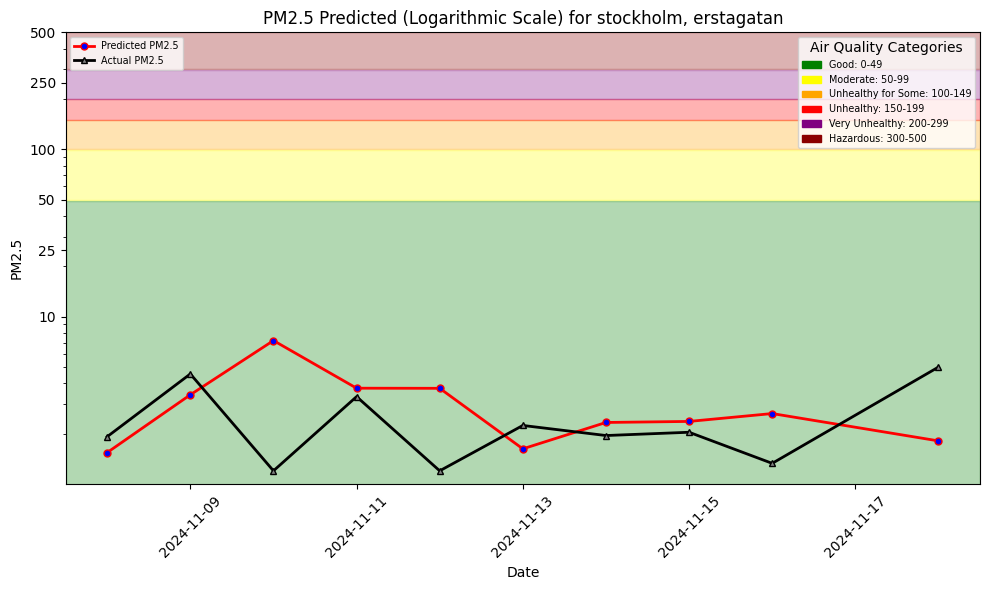

In [162]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---